In [2]:
import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import numpy as np
import os
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset, DataLoader, random_split, Dataset
from torchvision.io import read_image
from torch.autograd import Variable



2024-01-12 17:52:19.254776: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-12 17:52:19.285289: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 17:52:19.285321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 17:52:19.286357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 17:52:19.291230: I tensorflow/core/platform/cpu_feature_guar

In [3]:
train_path = glob("./archive/cityscapes_data/train/*")
valid_path = glob("./archive/cityscapes_data/val/*")

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [7]:
train_dataset = []
valid_dataset = []
#torch.utils.data.Dataset/Dataloader
class dataset(Dataset):
    def __init__(self, image_path, transform_img = None, transform_label = None):
        self.image_path = image_path
        self.transform_img = transform_img
        self.transform_label = transform_label

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        img = plt.imread(self.image_path[idx])

        image, label = img[:,:img.shape[1]//2], img[:,img.shape[1]//2:]

        if self.transform_img:
            image = self.transform_img(image)

        if self.transform_label:
            label = self.transform_label(label)

        return image, label

In [8]:
z_size = 10 # Size of z latent vector (i.e. size of generator input)
img_size = 64
ngpu = 16 # Number of GPUs available
nc = 3   # Number of channels in the training images. For color images this is 3

In [9]:
myTransformImage = transform.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size,img_size)),
    transform.ToTensor(),
#     transform.RandomHorizontalFlip(p = 0.9)
])

myTransformLabel = transform.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size,img_size)),
    transform.ToTensor(),
])

In [10]:
train_dataset = dataset(train_path, myTransformImage, myTransformLabel)
valid_dataset = dataset(valid_path, myTransformImage, myTransformLabel)


# Batches
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle = True)

In [11]:
#Print batch
def show_batch(whole_batch):
    images, ground_truths = whole_batch[0], whole_batch[1]
    images = images.numpy()
    ground_truths = ground_truths.numpy()
    fig, axes = plt.subplots(2, batch_size, figsize=(36, 4))

    for i in range(batch_size):
        axes[0, i].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Input{i}')

        axes[1, i].imshow(np.transpose(ground_truths[i], (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Output{i}')

    plt.show()

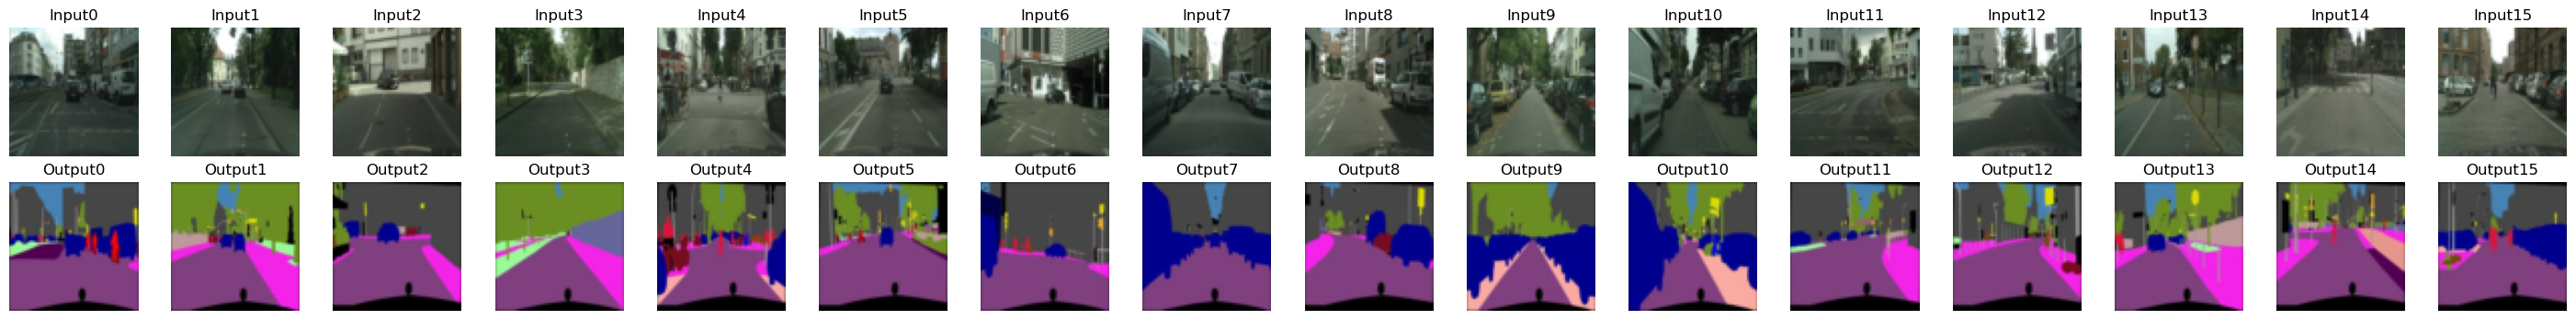

In [12]:
data_iter = iter(train_loader)
show_batch(next(data_iter))

In [13]:
#visualize images, pass the list

def show(pckt):

    iters = 1
    if len(pckt[0].shape) > 3:
        iters = pckt[0].shape[0]
        for j in range(iters):
            img = [None]*3
            n = 3
            labels = ['Label', 'Real', 'Predicted']
            fig, ax = plt.subplots(1, n, figsize=(10, 30))
            for i in range(n):

                x = torch.Tensor.cpu(pckt[j][i])
                x = x.detach().numpy()
                ax[i].imshow(np.transpose(x,(1,2,0)))
                ax[i].set_title(labels[i])
    else:
        img = [None]*3
        n = len(pckt)
        labels = ['Input', 'Output', 'Predicted']
        fig, ax = plt.subplots(1, n, figsize=(10, 30))
        for i in range(n):
            x = torch.Tensor.cpu(pckt[i])
            x = x.detach().numpy()
            ax[i].imshow(np.transpose(x,(1,2,0)))
            ax[i].set_title(labels[i])

torch.Size([16, 3, 64, 64])


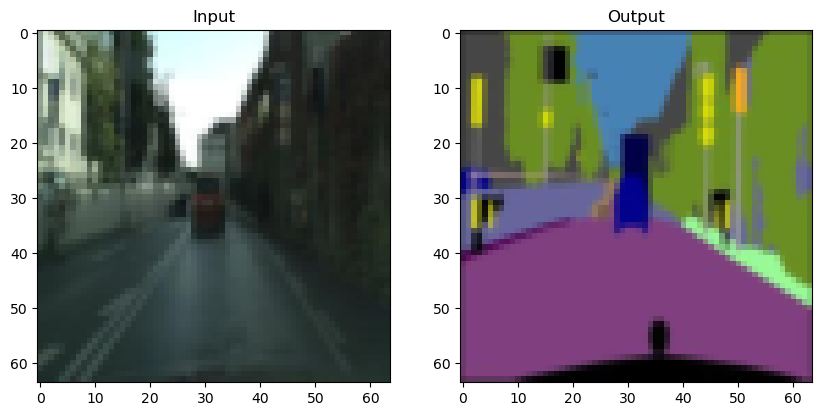

In [14]:
data_iter = iter(train_loader)
input, output = next(data_iter)

show([input[0], output[0]])
print(input.shape)

In [15]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace = True)

    def forward(self, x):
#         print(x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [16]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d(2,2)

    def forward(self, x):
        x = self.conv(x) #for skip connection feature map to decoder
        p = self.pool(x)
        return x, p

In [17]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.convT =  nn.ConvTranspose2d(in_c, out_c, kernel_size = 2, padding = 0, stride = 2)
        self.conv = conv_block(2*out_c, out_c)

    def forward(self, inputs, skips):
        x = self.convT(inputs)
        x = torch.cat([x, skips], axis = 1)
        x = self.conv(x)
        return x

In [18]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        """"Encoder part"""

        self.en1 = encoder_block(3, 64)
        self.en2 = encoder_block(64, 128)
        self.en3 = encoder_block(128, 256)
        self.en4 = encoder_block(256, 512)

        """Bottleneck"""

        self.b = conv_block(512, 1024)


        """decoder part"""

        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)


        """Classifier"""
        self.outputs = nn.Conv2d(64, 3, kernel_size=1, padding=0)

    def forward(self, input):
#         print(input.shape)
        s1, p1 = self.en1(input)
        s2, p2 = self.en2(p1)
        s3, p3 = self.en3(p2)
        s4, p4 = self.en4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        out = self.outputs(d4)

        return out

In [19]:
model = Unet().float().to(device)

epochs = 30

lr = 0.01

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
train_loss = []
val_loss = []
# model.to(device)
for epoch in range(epochs):
    trainloss = 0
    valloss = 0
    c = 0
    for img, lab in tqdm(train_loader):
        optimizer.zero_grad()
        img = img.to(device)
        lab = lab.to(device)
        output = model(img)
        loss = loss_func(output, lab)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()


        if epoch % 5 == 0 and c < 2:
            show([img[0], lab[0], output[0]])
            plt.show()
            c += 1
    train_loss.append(trainloss/len(train_loader))



    for img, lab in tqdm(valid_loader):
        img = img.to(device)
        lab = lab.to(device)
        output = model(img)
        loss = loss_func(output, lab)
        valloss += loss.item()
    val_loss.append(valloss/len(valid_loader))

    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(epoch,train_loss[-1],val_loss[-1]))

In [46]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Unet_segmentation.pth')

In [21]:
loaded_model = Unet().float().to(device)
loaded_model.load_state_dict(torch.load('./Unet_segmentation.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


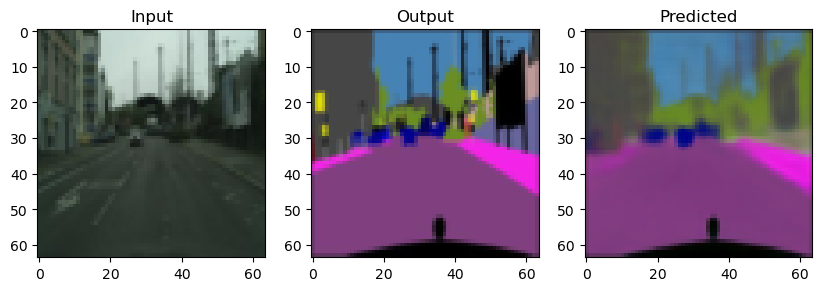

In [22]:
data_iter = iter(train_loader)
input, output = next(data_iter)
input = input.to(device)
output =output.to(device)
predict = loaded_model(input).to(device)
show([input[0], output[0], predict[0]])
plt.show()

In [24]:
def pixel_wise_accuracy(prediction, target):
    """
    Compute Pixel-wise Accuracy.

    Args:
        prediction (numpy array or torch tensor): Predicted labels.
        target (numpy array or torch tensor): Ground truth labels.

    Returns:
        float: Pixel-wise Accuracy.
    """
    if isinstance(prediction, torch.Tensor):
        prediction = prediction.cpu().numpy()

    if isinstance(target, torch.Tensor):
        target = target.cpu().numpy()

    lower_bound = -7/255
    upper_bound = 7/255

    correct_pixels = np.sum((prediction >= target + lower_bound) & (prediction <= target + upper_bound))
    total_pixels = np.prod(prediction.shape)


    return correct_pixels / total_pixels

#Generate random noise and labels
data_iter = iter(train_loader)
input, output = next(data_iter)
input = input.to(device)
output = output.to(device)
#Forward pass through the generator
generated_image = loaded_model(input).data.cpu().to(device)
# show([input[0], output[0], generated_image[0]])
# plt.show()
#Compute Pixel Accuracy
accuracy = pixel_wise_accuracy(generated_image, output)

print(f"Pixel-wise Accuracy on Trainset: {accuracy * 100:.2f}%")

Pixel-wise Accuracy on Trainset: 56.75%
